In [1]:
!pip install tensorflow_text

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [3]:
import pandas as pd

In [4]:
df= pd.read_csv('/content/spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

There is clearly an imbalance, we need to handle imbalance.

Refer: https://colab.research.google.com/drive/1H-1VeTWd8yLHBxDtT5MWr_Fd_1lnoD4f#scrollTo=2kUnJbVcvyLh

In [6]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [7]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [8]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [9]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [10]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [11]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)

In [12]:
df_balanced.sample(5)

,Category,Message,spam
2121,ham,"Argh my 3g is spotty, anyway the only thing I ...",0
4875,ham,Wat happened to the cruise thing,0
105,ham,Umma my life and vava umma love you lot dear,0
4104,spam,U have a secret admirer who is looking 2 make ...,1
1037,ham,"No my blankets are sufficient, thx",0


In [13]:
df_balanced['Message']

4027                              Oh ok.. Wat's ur email?
1212    Ok then i will come to ur home after half an hour
4510                        Ü takin linear algebra today?
3827    Goodmorning,my grandfather expired..so am on l...
5451    Just sing HU. I think its also important to fi...
                              ...                        
5537    Want explicit SEX in 30 secs? Ring 02073162414...
5540    ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547    Had your contract mobile 11 Mnths? Latest Moto...
5566    REMINDER FROM O2: To get 2.50 pounds free call...
5567    This is the 2nd time we have tried 2 contact u...
Name: Message, Length: 1494, dtype: object

In [14]:
df_balanced['spam']

4027    0
1212    0
4510    0
3827    0
5451    0
       ..
5537    1
5540    1
5547    1
5566    1
5567    1
Name: spam, Length: 1494, dtype: int64

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [16]:
X_train.head()

2025              U having lunch alone? I now so bored...
552     Hurry up, I've been weed-deficient for like th...
2492           Greetings me, ! Consider yourself excused.
1502    HOT LIVE FANTASIES call now 08707509020 Just 2...
1687    todays vodafone numbers ending with 0089(my la...
Name: Message, dtype: object

Now lets import BERT model and get embeding vectors for few sample statements

In [35]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [36]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [37]:
get_sentence_embeding([
    "500$ discount. hurry up",
    "Venkatesh, Go for playing badminton"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435168 , -0.5132724 , -0.8884571 , ..., -0.7474884 ,
        -0.7531473 ,  0.91964483],
       [-0.7266939 , -0.5119761 , -0.8679904 , ..., -0.675503  ,
        -0.6608691 ,  0.6183698 ]], dtype=float32)>

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435172 , -0.51327294, -0.88845766, ..., -0.7474892 ,
        -0.7531475 ,  0.91964495],
       [-0.72669405, -0.51197624, -0.86799043, ..., -0.675503  ,
        -0.66086936,  0.61837023]], dtype=float32)>

In [38]:
#Get embeding vectors for few sample words. Compare them using cosine similarity
e = get_sentence_embeding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [39]:
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.760692  , -0.14219385,  0.49604586, ...,  0.42165312,
        -0.532214  ,  0.8031219 ],
       [-0.86023223, -0.2124296 ,  0.49156848, ...,  0.39797997,
        -0.60506296,  0.8447167 ],
       [-0.7128862 , -0.15463911,  0.384017  , ...,  0.3527875 ,
        -0.5099134 ,  0.734741  ],
       [-0.82533467, -0.35550597, -0.5906975 , ..., -0.01613778,
        -0.61417586,  0.8723029 ],
       [-0.75041336, -0.2681262 , -0.26689708, ...,  0.02839353,
        -0.5938098 ,  0.7974988 ],
       [-0.78544426, -0.2994976 ,  0.41027158, ...,  0.52225286,
        -0.49573594,  0.8150757 ]], dtype=float32)>

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.760692  , -0.14219385,  0.49604586, ...,  0.42165312,
        -0.532214  ,  0.8031219 ],
       [-0.86023223, -0.2124296 ,  0.49156848, ...,  0.39797997,
        -0.60506296,  0.8447167 ],
       [-0.7128862 , -0.15463911,  0.384017  , ...,  0.3527875 ,
        -0.5099134 ,  0.734741  ],
       [-0.82533467, -0.35550597, -0.5906975 , ..., -0.01613778,
        -0.61417586,  0.8723029 ],
       [-0.75041336, -0.2681262 , -0.26689708, ...,  0.02839353,
        -0.5938098 ,  0.7974988 ],
       [-0.78544426, -0.2994976 ,  0.41027158, ...,  0.52225286,
        -0.49573594,  0.8150757 ]], dtype=float32)>

In [40]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

array([[0.9911088]], dtype=float32)

Here banana and grapes are similar, closer to 1 means similar (cosine similarity)

In [41]:
cosine_similarity([e[0]],[e[5]])

array([[0.9571837]], dtype=float32)

array([[0.9571837]], dtype=float32)

Sequential vs Functional https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [42]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [44]:
len(X_train)

1120

1120

In [45]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [46]:
#Train the model
model.fit(X_train, y_train, epochs=1)

35/35 [==============================] - 608s 17s/step - loss: 0.6749 - accuracy: 0.5759 - precision: 0.5806 - recall: 0.5464


35/35 [==============================] - 601s 17s/step - loss: 0.6255 - accuracy: 0.6732 - precision: 0.6816 - recall: 0.6500


In [47]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 198s 16s/step - loss: 0.5799 - accuracy: 0.7273 - precision: 0.6557 - recall: 0.9572


[0.5799121856689453,
 0.7272727489471436,
 0.6556776762008667,
 0.9572192430496216]

12/12 [==============================] - 198s 16s/step - loss: 0.5409 - accuracy: 0.8182 - precision: 0.7511 - recall: 0.9519


[0.5408691763877869,
 0.8181818127632141,
 0.7510548233985901,
 0.9518716335296631]

In [30]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()


12/12 [==============================] - 196s 16s/step


In [31]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[ 93,  94],
       [  8, 179]])

Text(50.722222222222214, 0.5, 'Truth')

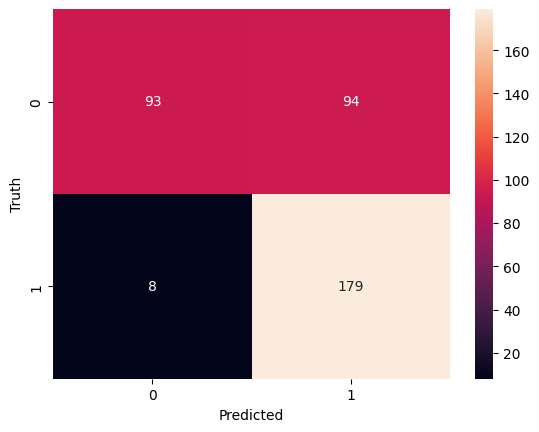

In [33]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [34]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.50      0.65       187
           1       0.66      0.96      0.78       187

    accuracy                           0.73       374
   macro avg       0.79      0.73      0.71       374
weighted avg       0.79      0.73      0.71       374

